## Welcome
This is an examplary analysis of the connectivity of the released part of the rat SSCx model of Blue Brain.
It illustrates the use of the "bluepysnap" and "conntility" packages to analyze its connectivity on a subcellular level.

Specifically, we will investigate whether groups of synapses originating from the same source neuron tend to innervate parts of the dendritic tree of the target neuron or are more randomly distributed.

### Setup
This file is packaged together with the actual circuit model on Zenodo. 
To run the analyses, you will first have to uncompress the archive containing the circuit model. After unpacking, you will find a file called "circuit_config.json". That file is for the purpose of the analyses the representation of the entire circuit. Note its path, and fill it in in the next cell as prompted.

The analysis packages conntility and bluepysnap can be found on the [Blue Brain github pages](https://github.com/BlueBrain).

Then, we begin by loading the required packages, and listing the different types of connectivity in the model. In the Sonata file format used to describe the model, connectivity is broken up into individual "EdgeSets" that represent different types of connections. Each has a name. Our model has the following EdgeSets:
 - S1nonbarrel_neurons__S1nonbarrel_neurons__chemical: The connections between the neurons in the model according to the Reimann et al., 2015 algorithm for local connectivity
 - midrange__S1nonbarrel_neurons__chemical: The connections between the neurons in the model according to the Reimann et al., 2019 algorithm for long range connectivity. Note: As this is long-range connectivity and this part of the model is rather small, there are not many connections.
 - external_S1nonbarrel_neurons__S1nonbarrel_neurons__chemical: Connections from parts of the full model that are not part of this release to neurons that are part of the release according to Reimann et al., 2015. This means that the _source_ of this connectivity is a set of "virtual" neurons that are associated with locations and types, but no morphologies or biophysical models. Hence, they cannot be simulated. Yet, their synapses can serve for certain types of stimuli.
 - external_midrange__S1nonbarrel_neurons__chemical: Connections from parts of the full model that are not part of this release to neurons that are part of the release according to Reimann et al., 2019. Same caveats as the previous.
 - POm__S1nonbarrel_neurons__chemical: Connections from the POm nucleus to neurons in the released model. The sources are also "virtual", hence the same caveats apply.
 - VPM__S1nonbarrel_neurons__chemical: Connections from the VPM nucleus to neurons in the released model. The sources are also "virtual", hence the same caveats apply.

In [3]:
ls -li O1_data_physiology/


total 89964
45747248 drwxr-x--- 2 fernando fernando     4096 May 16  2023 atlas/
45747239 -rw-rw---- 1 fernando fernando     4016 Nov  1 15:26 circuit_config.json
45747271 drwxr-x--- 2 fernando fernando     4096 May 16  2023 emodels_hoc/
45747238 -rw-rw---- 1 fernando fernando      138 May 16  2023 license.txt
45747242 -rw-rw---- 1 fernando fernando 30963387 May 16  2023 mapping.json
45747255 drwxr-xr-x 2 fernando fernando     4096 Jun 20 05:04 mod/
45747312 drwxrwxr-x 3 fernando fernando    16384 Nov 11 17:51 morphologies/
45747240 -rw-rw---- 1 fernando fernando  2859666 Jun  9 12:01 node_sets.json
45747241 -rw-rw---- 1 fernando fernando 20874428 May 16  2023 nodes_external_midrange__S1nonbarrel_neurons__chemical.h5
45747243 -rw-rw---- 1 fernando fernando 37357728 May 16  2023 nodes_external_S1nonbarrel_neurons__S1nonbarrel_neurons__chemical.h5
45747244 drwxrwx--- 2 fernando fernando     4096 May 16  2023 POm/
45747251 drwxrwx--- 2 fernando fernando     4096 Nov 10 16:19 S1nonbarrel_n

In [7]:
import conntility
import pandas
import numpy
import bluepysnap as snap

from matplotlib import pyplot as plt
%matplotlib inline

# !!! FILL IN LOCATION OF circuit_config.json HERE !!!
cfg_json = "/home/fernando/Documents/SCx_model/O1_data_physiology/circuit_config.json"

# Load circuit and list edge sets
circ = snap.Circuit(cfg_json)
for con_name, con in circ.edges.items():
    print("""
    Connectome {0} connects
        {1} and {2}
    """.format(con_name, con.source.name, con.target.name))



    Connectome POm__S1nonbarrel_neurons__chemical connects
        POm and S1nonbarrel_neurons
    

    Connectome S1nonbarrel_neurons__S1nonbarrel_neurons__chemical connects
        S1nonbarrel_neurons and S1nonbarrel_neurons
    

    Connectome VPM__S1nonbarrel_neurons__chemical connects
        VPM and S1nonbarrel_neurons
    

    Connectome external_S1nonbarrel_neurons__S1nonbarrel_neurons__chemical connects
        S1nonbarrel_neurons and S1nonbarrel_neurons
    

    Connectome external_midrange__S1nonbarrel_neurons__chemical connects
        S1nonbarrel_neurons and S1nonbarrel_neurons
    

    Connectome midrange__S1nonbarrel_neurons__chemical connects
        S1nonbarrel_neurons and S1nonbarrel_neurons
    


In this example, we will work with  "S1nonbarrel_neurons__S1nonbarrel_neurons__chemical", i.e. the local recurrent connectivity within the model.

However, we begin by loading the basic properties of some neurons.

In [8]:
# A dict defines which node (neuron) properties to load. Here, we load:
# The coordinates of their somas in the standard coordinate system (i.e. x is anterior-posterior, etc.)
# The morphological type (mtype) of neurons
#
# For more features of the "load_config" dict, check the conntility documentation
to_load = {
    "loading":{
      "properties": ["x", "y", "z", "mtype", "morphology"]
    },
    "filtering":[  # In this example, we are interested in L5_TPC:A type neurons
        {
            "column": "mtype",
            "values": ["L5_TPC:A"]
        }
    ]
}
# Name of the edge set to load.
connectome="S1nonbarrel_neurons__S1nonbarrel_neurons__chemical"
# Look up node set that receives the connections
node_set = circ.edges[connectome].target.name

nrn = conntility.circuit_models.neuron_groups.load_filter(circ, to_load, node_population=node_set)

display(nrn)

,node_ids,morphology,mtype,x,y,z
193763,193763,dend-rp090908_c2_axon-rat_20140925_RH1_Exp1_ce...,L5_TPC:A,3723.900067,-1192.689587,-2142.302811
193764,193764,dend-vd111206_idB_axon-C060114A2_-_Scale_x1.00...,L5_TPC:A,3988.913136,-649.690934,-2170.622766
193765,193765,dend-mtC130301A_idB_axon-C060110A2_-_Scale_x1....,L5_TPC:A,4173.587767,-1480.056963,-2845.078588
193766,193766,dend-C040896A-P2_axon-rp110616_C1_idA_-_Scale_...,L5_TPC:A,3565.030273,-1201.997162,-2456.220627
193767,193767,dend-rat_20140925_RH1_Exp1_cell2_axon-rat_2016...,L5_TPC:A,4188.670754,-1425.417409,-2753.787696
...,...,...,...,...,...,...
210494,210494,dend-rat_P16_S1_RH3_20140129_axon-C060109A2_-_...,L5_TPC:A,4006.333165,-917.535639,-2612.236998
210495,210495,C060110A2_-_Scale_x1.000_y0.950_z1.000,L5_TPC:A,4159.132148,-847.725135,-2625.784951
210496,210496,dend-rat_20150119_LH1_cell1_axon-rp110616_C1_idA,L5_TPC:A,3769.453198,-1088.295962,-2084.008417
210497,210497,rat_20151212_LH3_cell1,L5_TPC:A,3564.445132,-1478.179003,-2223.777396


Here, we perform an analysis only for a single of the L5_TPC:A neurons. 
In production, one would iterate over them...


We build a MorphologyPathDistanceCalculator for the neuron that let's us quickly calculate path distances (along the dendrite) of synapses innervating the neuron

In [9]:
from conntility.subcellular import MorphologyPathDistanceCalculator as md_calc

rnd_node_id = nrn["node_ids"].iloc[0]  # pick "random" neuron
morph = circ.nodes[node_set].morph.get(rnd_node_id, extension="asc")  # load its morphology
obj = md_calc(morph)  # create helper object

Then we load all synapses innervating the neuron

In [10]:
conn = circ.edges[connectome]
# The following is a list of the proeprties we need to load. You can get a
# list of all available ones as follows: print(conn.property_names)
syns = conn.afferent_edges(rnd_node_id, properties=["@source_node", "afferent_section_id", "afferent_segment_id",
                                                    "afferent_segment_offset"])
syns = syns.set_index("@source_node", drop=True)

Now we can use "obj.path_distances" with a subset of the loaded synapse info to rapidly calculate the pairwise distances between those synapses.

We now do the following: For each source neuron, consider the synapses it forms onto the exemplary target cell. Calculate the mean pairwise path distances, and compare to a random control where we sample the same number of synapses, but randomly.

In [11]:
def for_single_data(df):
    pd_data = obj.path_distances(df)
    pd_data = pd_data[numpy.triu_indices_from(pd_data, 1)]
    return pd_data

def for_single_control(df):
    L = len(df)
    idxx = numpy.random.choice(len(syns), L, replace=False)
    return for_single_data(syns.iloc[idxx])

def for_single_zscored(df, n_rnd=25):
    if len(df) == 0: return numpy.NaN
    mn_data = for_single_data(df).mean()
    mn_ctrl = [for_single_control(df).mean() for _ in range(n_rnd)]
    return (mn_data - numpy.mean(mn_ctrl)) / numpy.std(mn_ctrl)

innervation_pd_z = syns.groupby(level=0).apply(for_single_zscored)

We calculate means per m-type and plot

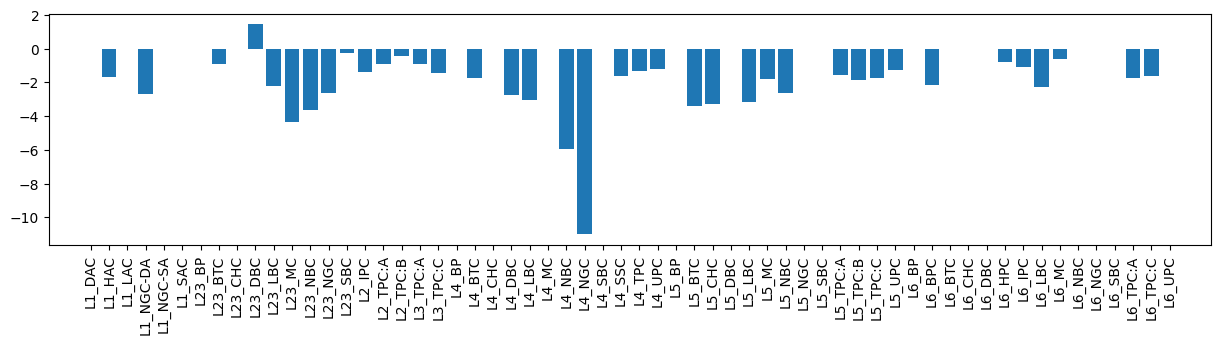

In [14]:
from matplotlib import pyplot as plt

# We load separately the "mtype" of the source neurons:
src_mtypes = circ.nodes[circ.edges[connectome].source.name].get(innervation_pd_z.index, properties="mtype")
syns["mtype"] = src_mtypes[syns.index]  # Also attach to "syns" for a later analysis

per_mtype = pandas.concat([innervation_pd_z, src_mtypes], axis=1).groupby("mtype")[0].mean()

ax = plt.figure(figsize=(15, 3)).gca()
ax.bar(range(len(per_mtype)), per_mtype.values)
ax.set_xticks(range(len(per_mtype))); _ = ax.set_xticklabels(per_mtype.index, rotation="vertical")

We find that for certain m-types the synapses from the same source neuron are significantly closer together than expected.
Is this trend only visible on the per-pair level? I.e. when we consider the path distances from _all_ neurons of the mtype together, how does the the trend look then?

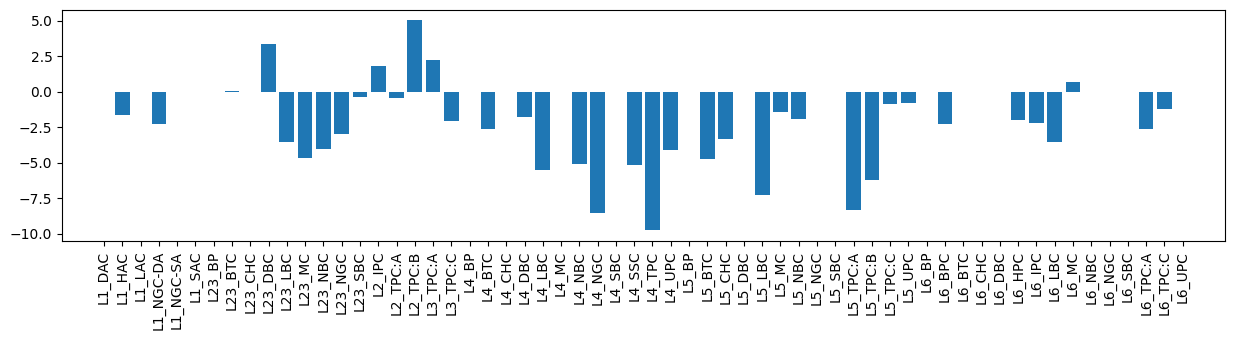

In [15]:
innervation_pd_mtype = syns.groupby("mtype").apply(for_single_zscored)

ax = plt.figure(figsize=(15, 3)).gca()
ax.bar(range(len(innervation_pd_mtype)), innervation_pd_mtype.values)
ax.set_xticks(range(len(innervation_pd_mtype)))
_ = ax.set_xticklabels(innervation_pd_mtype.index, rotation="vertical")

Other types suddenly pop out..?
This may be due to sampling just a single target neuron though. Nevertheless, let's plot the two results against each other.

In [20]:
import numpy as np

Text(0, 0.5, 'Per mtype')

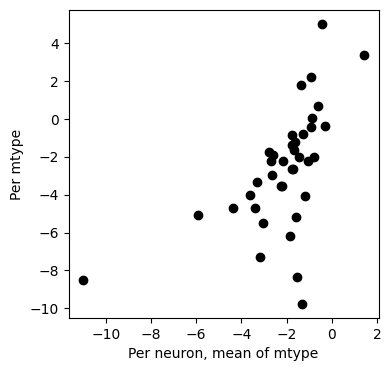

In [21]:
per_mtype = per_mtype[innervation_pd_mtype.index]  # Ensure they have the same order
ax = plt.figure(figsize=(4, 4)).gca()

ax.plot(np.array(per_mtype), np.array(innervation_pd_mtype), 'ok')
ax.set_xlabel("Per neuron, mean of mtype")
ax.set_ylabel("Per mtype")